# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [58]:
data = pd.read_excel('geo.xlsx', sheet_name='Sheet1')
data

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1
...,...,...,...,...
108801,108801,37.454528,55.792331,-1
108802,108802,37.384325,55.899068,-1
108803,108803,37.421066,55.848756,1
108804,108804,37.448509,55.793065,-1


In [59]:
data = data.drop('Unnamed: 0', axis=1)

In [60]:
data.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


Выведем все координаты на график.

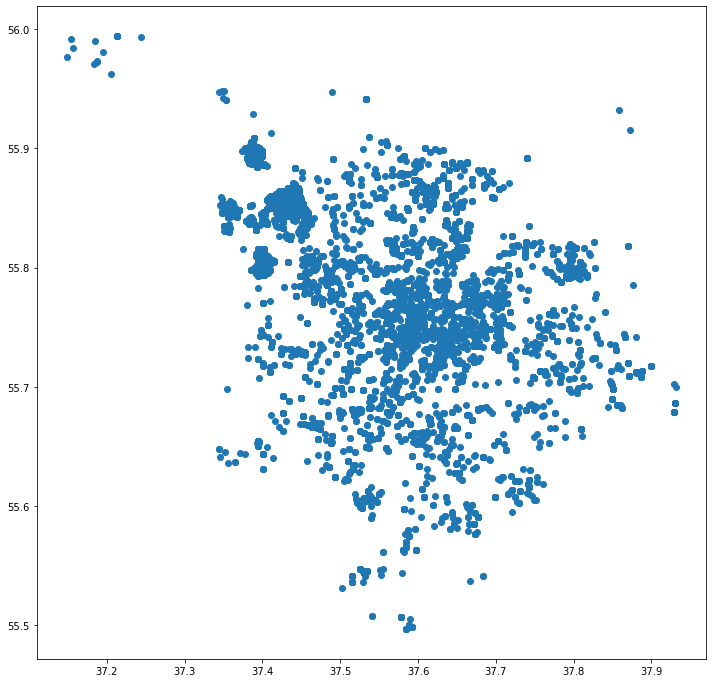

In [5]:
plt.figure(figsize=[12,12])
plt.scatter(data.x, data.y)

Видно, что по общему распределению голосов нельзя сделать выводы о количестве кластеров и их расположении. Видны районы с более высокой плотностью точек, чем в других. Это, например, не позволит корректно отработать алгоритму kmeans. Будем пробовать различные алгоритмы и смотреть на результаты.

In [6]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.metrics import adjusted_rand_score, silhouette_score

Попробуем сначала алгоритм kmeans. Определим оптимальное число кластеров с помощью графика локтя.

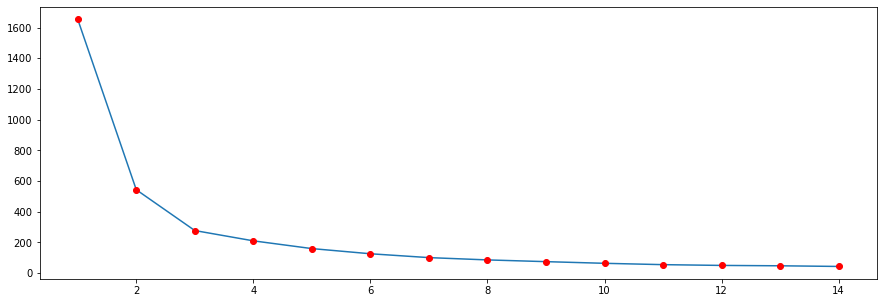

In [51]:
k_inertia = []
ks = range(1, 15)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data[['x', 'y']])
    k_inertia.append(clf_kmeans.inertia_)
    
plt.figure(figsize=[15,5])    
plt.plot(ks, k_inertia)
plt.plot(ks, k_inertia ,'ro')

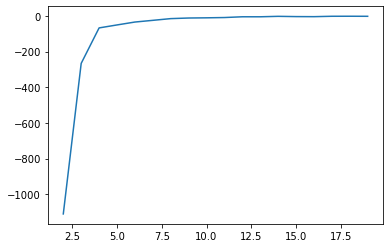

In [19]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)x

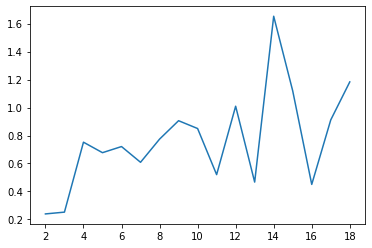

In [20]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [21]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

Расчёт показывает оптимальное количество кластеров 2. Действительно, и по графику можно видеть, что уже после 2-3 кластеров качество разбиения перестаёт резко улучшаться. Попробуем несколько различных разбиений.

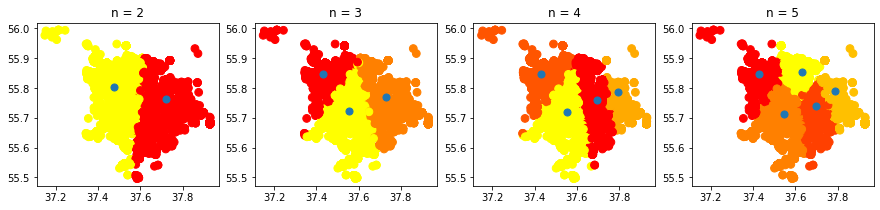

In [38]:
sizes = [2, 3, 4, 5]
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for ax, i in zip(axes, sizes):
    kmeans = KMeans(n_clusters=i)
    clusters = kmeans.fit_predict(data[['x', 'y']])
    ax.scatter(data.x, data.y, c=clusters, cmap='autumn', s=60)
    ax.set_title('n = {}'.format(i))
    
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], s=50)

Другие алгоритмы для работы требуют слишком большого объёма памяти. Искусственно уменьшим датасет и попробуем посмотреть работу алгоритмов на его части.

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
data_reduced = data.sample(frac=0.1)

In [55]:
algorithms = [
    AffinityPropagation(),
    KMeans(n_clusters=5),
    AgglomerativeClustering(n_clusters=5),
    DBSCAN()
]

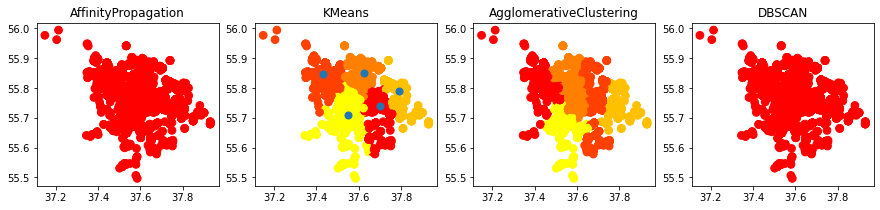

In [56]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for ax, algorithm in zip(axes, algorithms):
    # кластеризуем и выводим картинку
    clusters = algorithm.fit_predict(data_reduced[['x', 'y']].values)
    ax.scatter(data_reduced.x, data_reduced.y, c=clusters, cmap='autumn', s=60)
    ax.set_title(algorithm.__class__.__name__)
    
    # если есть центры кластеров - выведем их
    if algorithm.__class__.__name__ in {'KMeans', 'AffinityPropagation'}:
        centers = algorithm.cluster_centers_
        ax.scatter(centers[:, 0], centers[:, 1], s=50)

**AffinityPropagation и DBScan не отработали...**